# DUD-E enrichment

## preparation

In [1]:
import os, sys, itertools, glob, re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

In [2]:
possible_models = {'esvr': 'Epsilon-Support Vector Regression',
                   'erf': 'Extremely Random Forest',
                   'lr': 'LinearRegression',
                   'knn': 'Nearest-Neighbor',
                   'dnn': 'RASPDeep',
                   'rf': 'Random Forest',
                   'svr': 'Support Vector Regression'}
modelstr = " ".join(possible_models)
modelstr

'esvr erf lr knn dnn rf svr'

In [3]:
n_repls = 1 
n_cores = 8

weight_dir = "../../../weights/" 


work_path = "../enrich_results"
os.makedirs(work_path, exist_ok=True)


dud_path = "../../../dude"

In [4]:
with open(dud_path + "/list") as f:
    dud_names = [name.strip() for name in f.readlines()]
len(dud_names)

102

In [5]:
with open(dud_path + "/list_excluded_pockets") as f:
    exclusion_names = [name.strip() for name in f.readlines()]
len(exclusion_names)

47

In [6]:
special_groups = {
    "list_cyp": "Cytochrome P450",
     "list_gpcr": "GPCR",
     "list_ionchannel" : "Ion channel",
     "list_kinases": "Kinase", 
     "list_metalloenzyme": "Metal containing enzyme",
    "list_nuclear": "Nuclear receptor",
    "list_protease": "Protease",
        "list_miscellaneous": "Miscellaneous", 

}

special_lists ={}

for grp_name in special_groups.keys():
    with open(dud_path + "/" + grp_name) as f:
        special_lists[grp_name] = [name.strip() for name in f.readlines()]


special_map = {val: k for k, vals in special_lists.items() for val in vals}

In [7]:
# Sanity checks

In [8]:
len(special_map)

102

In [9]:
len(set(itertools.chain.from_iterable(special_lists.values())))

102

In [10]:
set(itertools.chain.from_iterable(special_lists.values())).symmetric_difference(dud_names)

set()

In [11]:
parameter_files = {}

subdirs = {}
for name in dud_names:
    
    parameter_file = "{}/{}_PARAMETERS_MILLION.txt".format(dud_path, name)
    parameter_files[name] = parameter_file 
    assert os.path.exists(parameter_file)
    
    subdirs[name] = {}
    for i in range(n_repls):
        tmp_out = os.path.join(work_path, name, str(i))
        subdirs[name][i] = tmp_out
        os.makedirs(tmp_out, exist_ok=True)
        
        ## Comment out to run the inference (keep commented to run nb without)
        #os.system(f"python ../infer.py -d {tmp_out} -w {weight_dir} -i {parameter_file} -m {modelstr} -s {i} -c {n_cores}")


In [12]:
def compute_ef_single(df, fractions=[0.01, 0.05, 0.1], ascending=True):
    actives = df['active'].sum()
    decoys = (~df['active']).sum()
    total = df.shape[0]
    assert total == actives + decoys
    efs = {}
    for frac in fractions:
        portion = int(total * frac)
        recovered = df.sort_values('value', ascending=ascending).iloc[:portion]['active'].sum()
        ef = (recovered / portion) / (actives / total)
        efs[str(frac)] = ef
    return {"actives": actives, "decoys": decoys, **efs}

In [13]:
def compute_ef_union(dfs, fractions=[0.01, 0.05, 0.1], ascending=True, active_str="AC_"):
    dfs = [df.sort_values('value', ascending=ascending) for df in dfs]
    actives = dfs[0]['active'].sum()
    decoys = (~dfs[0]['active']).sum()
    total = dfs[0].shape[0]
    assert total == actives + decoys
    efs = {}
    for frac in fractions:
        portion = int(total * frac)
        recover = set()
        for cands in zip(*[df['id'] for df in dfs]):
            if len(recover.union(cands)) > portion:
                break
            recover.update(cands)
        assert len(recover) <= portion
        assert portion - len(recover) < 7
        uniqued = pd.Series(list(recover))
        recovery_rate = uniqued.str.match(active_str).mean()
        efs[str(frac)] = recovery_rate / (actives / total)
    return efs

In [14]:
def mean_result_df(dfs):
    id_frame = dfs[0][['id', 'active']]
    mean_value = pd.concat([df['value'] for df in dfs], axis=1).mean(axis=1)
    mean_value = pd.Series(mean_value, name='value')
    return id_frame.join(mean_value)

In [15]:
def compute_ef_table(output_list):
    res = {}
    efs = {}
    for name in dud_names:
        res[name] = {}
        efs[name] = {}
        ids = pd.read_csv(parameter_files[name], sep=";", usecols=["PDBID"])["PDBID"].rename('id')
        for repl in range(n_repls):
            res[name][repl] = {}
            efs[name][repl] = {}
            for model in possible_models:
                res_file = os.path.join(output_list[name][repl], f"{model}.out")
                df = (pd.read_csv(res_file, delim_whitespace=True, header=None, names=['value', 'std'])
                        .drop(columns=['std']))
                assert df.shape[0] == ids.shape[0]
                dat = df.join(ids)
                dat['active'] = dat['id'].str.match('AC_')
                dat = dat.sort_values('value', ascending=True)
                res[name][repl][model] = dat
                efs[name][repl][model] = compute_ef_single(dat)
            efs[name][repl] = pd.DataFrame.from_records(efs[name][repl])
            mean_ensemble = compute_ef_single(mean_result_df(list(res[name][repl].values())))
            mean_ens_dknn = compute_ef_single(mean_result_df([val for key, val in res[name][repl].items() if key != "knn"]))
            union = compute_ef_union(res[name][repl].values())
            union_dknn = compute_ef_union(val for key, val in res[name][repl].items() if key != "knn")
            efs[name][repl] = efs[name][repl].join(
                pd.DataFrame({'mean_ensemble': pd.Series(mean_ensemble),
                              'mean_ens_dknn': pd.Series(mean_ens_dknn),
                              'union': pd.Series(union),
                              'union_dknn': pd.Series(union_dknn),
                             }))
        efs[name] = pd.concat(efs[name], names=['replicate'])


    efs = pd.concat(efs, names=['system'])
    return efs, res

In [16]:
enrichments, details = compute_ef_table(subdirs)


In [17]:
value_order = ['erf', 'rf', 'dnn', 'knn', 'svr', 'esvr', 'lr', 
               'union', 'union_dknn', 'mean_ensemble']

enrichments = enrichments[value_order]

enrichments.index.rename('level', level=2, inplace=True)
enrichments.columns.rename('method', inplace=True)


In [18]:
def texify_val_error(values, nan_text="NA", sig_digits=2, force_sig=False):
    nan_check = pd.isna(values)
    if nan_check[0]:
        return nan_text
    elif nan_check[1] or values[1] == 0:
        return "{{:.{}f}}".format(sig_digits).format(values[0])
    else:
        error = "{:.2g}".format(values[1])
        split_error = error.split(".")
        if len(split_error) == 2:
            sig = len(split_error[1])
            if force_sig:
                sig = min(sig, sig_digits)
            value = '{{:.{prec}f}}'.format(prec=sig).format(values[0])
            error = '{{:.{prec}f}}'.format(prec=sig).format(values[1])
        else:
            error = str(round(values[1]))
            value = str(round(values[0]))
        return "\\num{{{} \\pm {}}}".format(value, error)


def texify_df_groupby(df, axis=1, stats=('mean', 'std'), force_sig=False):
    trans_func=None
    if force_sig:
        trans_func = functools.partial(texify_val_error, force_sig=True)
    else:
        trans_func = texify_val_error
    result = (df.agg([*stats])
         .groupby(axis=axis, level=0).transform(trans_func)
         .xs("mean", axis=axis, level=1)
         )
    return result

# Results

In [19]:
enrichments.stack().groupby(level=['level', 'method']).agg(['mean', 'std']).unstack().T

level                  actives        decoys      0.01      0.05       0.1
     method                                                               
mean erf            396.490196  13868.813725  1.776197  1.520414  1.317791
     rf             396.490196  13868.813725  1.860837  1.526930  1.343555
     dnn            396.490196  13868.813725  1.620120  1.389520  1.279942
     knn            396.490196  13868.813725  1.480053  1.343209  1.230028
     svr            396.490196  13868.813725  2.584095  1.871992  1.620882
     esvr           396.490196  13868.813725  2.302081  1.574991  1.367459
     lr             396.490196  13868.813725  2.749839  1.977659  1.665252
     union                 NaN           NaN  2.374044  1.818376  1.583583
     union_dknn            NaN           NaN  2.477226  1.827582  1.570041
     mean_ensemble  396.490196  13868.813725  2.317256  1.818877  1.556814
std  erf            306.338444  10815.847085  2.500221  1.373628  0.944782
     rf             306.338444  10815.847085  2.420776  1.492408  0.983850
     dnn            306.338444  10815.847085  1.992074  1.170485  0.869720
     knn            306.338444  10815.847085  1.931480  1.312165  0.876799
     svr            306.338444  10815.847085  3.137788  1.572663  1.148859
     esvr           306.338444  10815.847085  3.469504  1.529612  0.964180
     lr             306.338444  10815.847085  3.429736  1.722909  1.199841
     union                 NaN           NaN  2.298009  1.396919  0.994307
     union_dknn            NaN           NaN  2.719129  1.494285  1.039085
     mean_ensemble  306.338444  10815.847085  3.042869  1.629992  1.081110

In [20]:
enrichments

method                             erf            rf           dnn  \
system replicate level                                               
aa2ar  0         actives    844.000000    844.000000    844.000000   
                 decoys   32063.000000  32063.000000  32063.000000   
                 0.01         1.896138      1.659121      0.355526   
                 0.05         2.986417      2.346471      0.971771   
                 0.1          2.417576      2.239813      0.948069   
...                                ...           ...           ...   
xiap   0         actives    129.000000    129.000000    129.000000   
                 decoys    5213.000000   5213.000000   5213.000000   
                 0.01         0.000000      0.000000      0.000000   
                 0.05         0.155097      0.155097      0.000000   
                 0.1          0.387742      0.077548      0.000000   

method                             knn           svr          esvr  \
system replicate level                                               
aa2ar  0         actives    844.000000    844.000000    844.000000   
                 decoys   32063.000000  32063.000000  32063.000000   
                 0.01         1.659121      1.185086      2.370172   
                 0.05         1.422103      1.445805      1.516910   
                 0.1          1.339147      1.078428      1.244341   
...                                ...           ...           ...   
xiap   0         actives    129.000000    129.000000    129.000000   
                 decoys    5213.000000   5213.000000   5213.000000   
                 0.01         0.000000      0.000000      0.000000   
                 0.05         0.620387      0.465290      0.000000   
                 0.1          0.387742      1.085678      0.000000   

method                              lr     union  union_dknn  mean_ensemble  
system replicate level                                                       
aa2ar  0         actives    844.000000       NaN         NaN     844.000000  
                 decoys   32063.000000       NaN         NaN   32063.000000  
                 0.01         2.133155  1.426439    1.669268       2.251664  
                 0.05         1.635419  1.730226    1.873575       1.588016  
                 0.1          1.350998  1.849297    1.896714       1.457656  
...                                ...       ...         ...            ...  
xiap   0         actives    129.000000       NaN         NaN     129.000000  
                 decoys    5213.000000       NaN         NaN    5213.000000  
                 0.01         0.000000  0.000000    0.000000       0.000000  
                 0.05         0.620387  0.000000    0.000000       0.000000  
                 0.1          1.085678  0.389200    0.232645       0.232645  

[510 rows x 10 columns]

In [21]:
enrichments.drop(index=['actives', 'decoys'], level='level').groupby(level=['system', 'level']).agg('mean')

method             erf        rf       dnn       knn       svr      esvr  \
system level                                                               
aa2ar  0.01   1.896138  1.659121  0.355526  1.659121  1.185086  2.370172   
       0.05   2.986417  2.346471  0.971771  1.422103  1.445805  1.516910   
       0.1    2.417576  2.239813  0.948069  1.339147  1.078428  1.244341   
abl1   0.01   0.682852  0.682852  1.707131  1.024279  4.097114  2.731409   
       0.05   0.881356  0.474576  1.423729  1.084746  3.728814  2.169492   
...                ...       ...       ...       ...       ...       ...   
wee1   0.05   0.438714  0.146238  0.438714  0.584952  4.679613  0.292476   
       0.1    0.365021  0.292017  0.730042  0.365021  3.431195  0.803046   
xiap   0.01   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
       0.05   0.155097  0.155097  0.000000  0.620387  0.465290  0.000000   
       0.1    0.387742  0.077548  0.000000  0.387742  1.085678  0.000000   

method              lr     union  union_dknn  mean_ensemble  
system level                                                 
aa2ar  0.01   2.133155  1.426439    1.669268       2.251664  
       0.05   1.635419  1.730226    1.873575       1.588016  
       0.1    1.350998  1.849297    1.896714       1.457656  
abl1   0.01   4.438540  2.125139    2.145187       2.731409  
       0.05   4.000000  1.908548    1.898305       2.372881  
...                ...       ...         ...            ...  
wee1   0.05   4.240899  2.193568    2.339806       1.169903  
       0.1    3.285187  1.689706    1.681736       0.876050  
xiap   0.01   0.000000  0.000000    0.000000       0.000000  
       0.05   0.620387  0.000000    0.000000       0.000000  
       0.1    1.085678  0.389200    0.232645       0.232645  

[306 rows x 10 columns]

### Worst performing systems

In [22]:
(enrichments
 .drop(index=['actives', 'decoys'], level='level')
 .groupby(level=['system', 'level'])
 .agg('mean')
 .xs("0.01", level="level")
 .sort_values("union")).head(30)

method,erf,rf,dnn,knn,svr,esvr,lr,union,union_dknn,mean_ensemble
system,,,,,,,,,,
xiap,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
fkb1a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
kif11,0.000000,0.000000,0.000000,0.508258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
kith,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cxcr4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ppard,0.347737,0.347737,0.000000,0.000000,0.347737,0.000000,0.347737,0.000000,0.000000,0.000000
pygm,0.000000,0.889602,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ampc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pyrd,0.755402,0.000000,2.266206,0.755402,1.510804,0.755402,0.755402,0.000000,0.000000,0.755402


### Best performing systems

In [23]:
(enrichments
 .drop(index=['actives', 'decoys'], level='level')
 .groupby(level=['system', 'level'])
 .agg('mean')
 .xs("0.01", level="level")
 .sort_values("union", ascending=False)).head(30)

method,erf,rf,dnn,knn,svr,esvr,lr,union,union_dknn,mean_ensemble
system,,,,,,,,,,
gria2,10.486080,7.441734,5.412170,8.456516,13.868687,14.545208,14.545208,10.401515,10.913065,14.545208
glcm,12.288631,9.701551,0.000000,7.437856,7.114471,11.641861,10.024936,9.281150,9.769632,10.348321
aces,0.301618,2.262132,0.452426,0.603235,12.366321,18.700290,13.120365,8.725366,10.405807,14.628453
adrb1,1.748323,2.403943,7.867451,0.218540,5.682048,13.986580,5.900588,7.568825,9.572337,8.304532
ptn1,10.748070,10.300234,5.374035,1.343509,1.791345,1.791345,2.687018,7.190610,7.926088,4.478363
igf1r,4.883988,0.443999,5.771986,3.107992,5.771986,3.107992,7.547981,6.874822,6.281416,6.215985
drd3,1.831863,9.502789,0.915931,0.915931,8.014400,4.923131,10.876686,6.485642,7.441943,5.610080
nos1,5.560241,7.698795,5.132530,0.427711,9.837349,8.126506,10.265060,6.291139,9.091463,10.265060
vgfr2,1.451613,1.935484,7.419355,0.806452,10.645161,3.709677,11.290323,6.037676,6.664366,6.290323


### Subset analysis

In [24]:
(enrichments
         .drop(index=['actives', 'decoys'], level='level')
         .loc[:,'union']
         .unstack(level='level')
         .groupby(by=special_map, level='system')
         .agg(['mean', 'count'])
         .rename(index=special_groups)

)

0.01            0.05             0.1      
                             mean count      mean count      mean count
system                                                                 
Cytochrome P450          1.861178     2  1.245845     2  1.283842     2
GPCR                     4.297759     5  2.938339     5  2.177592     5
Ion channel              5.540312     2  2.152255     2  1.608480     2
Kinase                   3.044800    23  2.548342    23  2.148800    23
Metal containing enzyme  2.472830    18  1.655833    18  1.415726    18
Miscellaneous            1.834192    30  1.492136    30  1.406661    30
Nuclear receptor         1.734512    11  1.177954    11  1.110042    11
Protease                 1.564911    11  1.622551    11  1.412467    11

In [25]:
# Overview without nuisance factors in the pockets or surface only pockets
(enrichments
 .drop(index=['actives', 'decoys'], level='level')
 .groupby(level=['system', 'level'])
 .agg('mean')
 .xs("0.01", level="level").loc[set(dud_names).difference(exclusion_names)])

method,erf,rf,dnn,knn,svr,esvr,lr,union,union_dknn,mean_ensemble
system,,,,,,,,,,
fak1,0.879745,0.879745,1.759490,1.759490,4.398724,2.639234,5.278469,2.688109,3.651771,3.518979
adrb2,0.671141,2.013423,2.013423,0.671141,6.263982,13.422819,6.711409,6.007889,7.575558,3.579418
lck,2.932265,3.811944,3.958557,2.052585,7.184049,3.811944,9.090021,5.864530,6.348923,6.011143
tryb1,7.093117,9.457490,8.275304,4.137652,2.364372,9.457490,3.546559,5.910931,6.502024,7.093117
mk10,5.913978,5.376344,0.537634,2.688172,2.688172,0.537634,4.301075,0.570720,0.553683,4.838710
hxk4,0.000000,0.000000,3.168890,3.168890,0.000000,0.792222,0.000000,0.862642,1.584445,0.000000
andr,0.383072,0.957680,0.383072,2.106896,1.723824,0.766144,1.723824,1.783266,0.776497,1.149216
aces,0.301618,2.262132,0.452426,0.603235,12.366321,18.700290,13.120365,8.725366,10.405807,14.628453
grik1,0.668973,0.668973,2.006919,0.000000,0.668973,0.668973,0.668973,0.679109,0.668973,0.668973


In [26]:
(enrichments
         .drop(exclusion_names)
         .drop(index=['actives', 'decoys'], level='level')
         .loc[:,'union']
         .unstack(level='level')
         .groupby(by=special_map, level='system')
         .agg(['mean', 'count'])
         .rename(index=special_groups)
)

0.01            0.05             0.1      
                      mean count      mean count      mean count
system                                                          
GPCR              4.297759     5  2.938339     5  2.177592     5
Ion channel       5.540312     2  2.152255     2  1.608480     2
Kinase            2.943509    15  2.543682    15  2.161596    15
Miscellaneous     3.132972    14  2.218987    14  1.995620    14
Nuclear receptor  1.734512    11  1.177954    11  1.110042    11
Protease          1.871852     8  1.872168     8  1.567761     8

# output

In [27]:
method_renamer = {"erf": "eRF", 
                  "rf": "RF", 
                  "dnn": "DNN",
                  "svr": "lSVR", 
                  "esvr": "SVR", 
                  "knn": "kNN",  
                  "lr": "LR",
                  "mean_ensemble": "Mean",
                  "union_out": "Union",
                  "union_dknn": "Union w/o kNN"
                 }

In [28]:
# Make the publication table for Table 3
tf = partial(texify_val_error, force_sig=True, sig_digits=1)

full_dude = (enrichments.stack()
      .groupby(level=['level', 'method']).agg(['mean', 'std'])
      .unstack().T
      .groupby(axis=0, level='method').transform(tf)
      .xs('mean').drop(columns=['actives', 'decoys'])
      .rename(index=method_renamer))

filt_dude = (enrichments
      .drop(exclusion_names)
      .stack()
      .groupby(level=['level', 'method'])
      .agg(['mean', 'std'])
      .unstack().T
      .groupby(axis=0, level='method').transform(tf)
      .xs('mean').drop(columns=['actives', 'decoys'])
      .rename(index=method_renamer))


print(pd.concat([full_dude, filt_dude], axis=1, names=['Full DUD-E', 'w/o cofactor/surface binding'])
      .to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
level &               0.01 &               0.05 &                0.1 &               0.01 &               0.05 &                0.1 \\
method        &                    &                    &                    &                    &                    &                    \\
\midrule
eRF           &  \num{1.8 \pm 2.5} &  \num{1.5 \pm 1.4} &  \num{1.3 \pm 0.9} &  \num{2.0 \pm 3.0} &  \num{1.7 \pm 1.5} &  \num{1.0 \pm 1.0} \\
RF            &  \num{1.9 \pm 2.4} &  \num{1.5 \pm 1.5} &  \num{1.3 \pm 1.0} &  \num{2.3 \pm 2.8} &  \num{1.7 \pm 1.7} &  \num{1.4 \pm 1.1} \\
DNN           &  \num{2.0 \pm 2.0} &  \num{1.4 \pm 1.2} &  \num{1.3 \pm 0.9} &  \num{1.8 \pm 2.3} &  \num{1.6 \pm 1.3} &  \num{1.4 \pm 0.9} \\
kNN           &  \num{1.5 \pm 1.9} &  \num{1.3 \pm 1.3} &  \num{1.2 \pm 0.9} &  \num{1.8 \pm 2.4} &  \num{1.6 \pm 1.6} &  \num{1.0 \pm 1.0} \\
lSVR          &  \num{2.6 \pm 3.1} &  \num{1.9 \pm 1.6} &  \num{1.6 \pm 1.1} &  \num{2.6 \pm 3.3} &  \num{2

In [31]:
group_counts = enrichments.loc[(slice(None), 0, '0.01'), 'union'].groupby(by=special_map, level='system').count().rename('count')



print(group_counts.to_frame().join(
    enrichments
         .drop(index=['actives', 'decoys'], level='level')
         .loc[:,'union']
         .unstack(level='level')
         .groupby(by=special_map, level='system')
         .mean()
         .round(2)
)
         
      .rename(index=special_groups)
      .to_latex()
)

\begin{tabular}{lrrrr}
\toprule
{} &  count &  0.01 &  0.05 &   0.1 \\
system                  &        &       &       &       \\
\midrule
Cytochrome P450         &      2 &  1.86 &  1.25 &  1.28 \\
GPCR                    &      5 &  4.30 &  2.94 &  2.18 \\
Ion channel             &      2 &  5.54 &  2.15 &  1.61 \\
Kinase                  &     23 &  3.04 &  2.55 &  2.15 \\
Metal containing enzyme &     18 &  2.47 &  1.66 &  1.42 \\
Miscellaneous           &     30 &  1.83 &  1.49 &  1.41 \\
Nuclear receptor        &     11 &  1.73 &  1.18 &  1.11 \\
Protease                &     11 &  1.56 &  1.62 &  1.41 \\
\bottomrule
\end{tabular}



In [32]:
metadf = enrichments['lr'].unstack()[['actives', 'decoys']].groupby('system').first()
metadf

level,actives,decoys
system,,
aa2ar,844.0,32063.0
abl1,295.0,10885.0
ace,803.0,17144.0
aces,664.0,26373.0
ada,262.0,5472.0
...,...,...
tysy,311.0,6883.0
urok,306.0,9933.0
vgfr2,620.0,25280.0


In [33]:
percent_renamer = {"0.01": "1", "0.05": "5", "0.1": "10"}

ef_df = (enrichments
         .drop(columns=["mean_ensemble", "union_dknn"])
         .drop(index=['actives', 'decoys'], level='level')
         .groupby(level=['system', 'level'])
# With error
         #.agg(['mean', 'std'])
         #.groupby(axis=1, level=0)
         #.transform(tf)
         #.xs('mean', level=1, axis=1)
# Alternative just rounding:
         .agg('mean')
         .round(1)
# Make the necessary adaptations
         .rename(index=percent_renamer, level='level')
         .rename(columns=method_renamer)
         .reset_index()         
        )

ef_df["system"] = ef_df["system"].str.upper()

for i, k in enumerate(dud_names):
    ef_df.iloc[3*i+1, 0] = "Active: {:.0f}".format(metadf.loc[k, 'actives'])
    ef_df.iloc[3*i+2, 0] = "Decoys: {:.0f}".format(metadf.loc[k, 'decoys'])


ef_df


method,system,level,eRF,RF,DNN,kNN,lSVR,SVR,LR,union
0,AA2AR,1,1.9,1.7,0.4,1.7,1.2,2.4,2.1,1.4
1,Active: 844,5,3.0,2.3,1.0,1.4,1.4,1.5,1.6,1.7
2,Decoys: 32063,10,2.4,2.2,0.9,1.3,1.1,1.2,1.4,1.8
3,ABL1,1,0.7,0.7,1.7,1.0,4.1,2.7,4.4,2.1
4,Active: 295,5,0.9,0.5,1.4,1.1,3.7,2.2,4.0,1.9
...,...,...,...,...,...,...,...,...,...,...
301,Active: 137,5,0.4,0.1,0.4,0.6,4.7,0.3,4.2,2.2
302,Decoys: 6234,10,0.4,0.3,0.7,0.4,3.4,0.8,3.3,1.7
303,XIAP,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,Active: 129,5,0.2,0.2,0.0,0.6,0.5,0.0,0.6,0.0


In [34]:
latex_string = ef_df.to_latex(longtable=False, escape=False, index=False)
latex_string

'\\begin{tabular}{llrrrrrrrr}\n\\toprule\n        system & level &   eRF &    RF &  DNN &   kNN &  lSVR &   SVR &    LR &  union \\\\\n\\midrule\n         AA2AR &     1 &   1.9 &   1.7 &  0.4 &   1.7 &   1.2 &   2.4 &   2.1 &    1.4 \\\\\n   Active: 844 &     5 &   3.0 &   2.3 &  1.0 &   1.4 &   1.4 &   1.5 &   1.6 &    1.7 \\\\\n Decoys: 32063 &    10 &   2.4 &   2.2 &  0.9 &   1.3 &   1.1 &   1.2 &   1.4 &    1.8 \\\\\n          ABL1 &     1 &   0.7 &   0.7 &  1.7 &   1.0 &   4.1 &   2.7 &   4.4 &    2.1 \\\\\n   Active: 295 &     5 &   0.9 &   0.5 &  1.4 &   1.1 &   3.7 &   2.2 &   4.0 &    1.9 \\\\\n Decoys: 10885 &    10 &   0.8 &   0.5 &  1.2 &   0.9 &   3.1 &   1.7 &   3.2 &    1.8 \\\\\n           ACE &     1 &   3.0 &   0.6 &  0.4 &   3.1 &   0.5 &   1.9 &   0.5 &    1.0 \\\\\n   Active: 803 &     5 &   2.4 &   0.3 &  1.2 &   1.5 &   0.5 &   0.9 &   0.4 &    1.8 \\\\\n Decoys: 17144 &    10 &   1.9 &   0.7 &  1.4 &   1.1 &   0.6 &   1.1 &   0.7 &    1.6 \\\\\n          ACES & 

In [35]:
line_list = latex_string.split('\n')

# Separate the entities
for i, line in enumerate(line_list[4:-3]):
    print(line)
    if (i+1) % 3 == 0:
        print('\\hline')

         AA2AR &     1 &   1.9 &   1.7 &  0.4 &   1.7 &   1.2 &   2.4 &   2.1 &    1.4 \\
   Active: 844 &     5 &   3.0 &   2.3 &  1.0 &   1.4 &   1.4 &   1.5 &   1.6 &    1.7 \\
 Decoys: 32063 &    10 &   2.4 &   2.2 &  0.9 &   1.3 &   1.1 &   1.2 &   1.4 &    1.8 \\
\hline
          ABL1 &     1 &   0.7 &   0.7 &  1.7 &   1.0 &   4.1 &   2.7 &   4.4 &    2.1 \\
   Active: 295 &     5 &   0.9 &   0.5 &  1.4 &   1.1 &   3.7 &   2.2 &   4.0 &    1.9 \\
 Decoys: 10885 &    10 &   0.8 &   0.5 &  1.2 &   0.9 &   3.1 &   1.7 &   3.2 &    1.8 \\
\hline
           ACE &     1 &   3.0 &   0.6 &  0.4 &   3.1 &   0.5 &   1.9 &   0.5 &    1.0 \\
   Active: 803 &     5 &   2.4 &   0.3 &  1.2 &   1.5 &   0.5 &   0.9 &   0.4 &    1.8 \\
 Decoys: 17144 &    10 &   1.9 &   0.7 &  1.4 &   1.1 &   0.6 &   1.1 &   0.7 &    1.6 \\
\hline
          ACES &     1 &   0.3 &   2.3 &  0.5 &   0.6 &  12.4 &  18.7 &  13.1 &    8.7 \\
   Active: 664 &     5 &   0.4 &   1.6 &  1.8 &   0.9 &   6.3 &   6.3 &   6.7 &

# Overview figure 1% enrichment

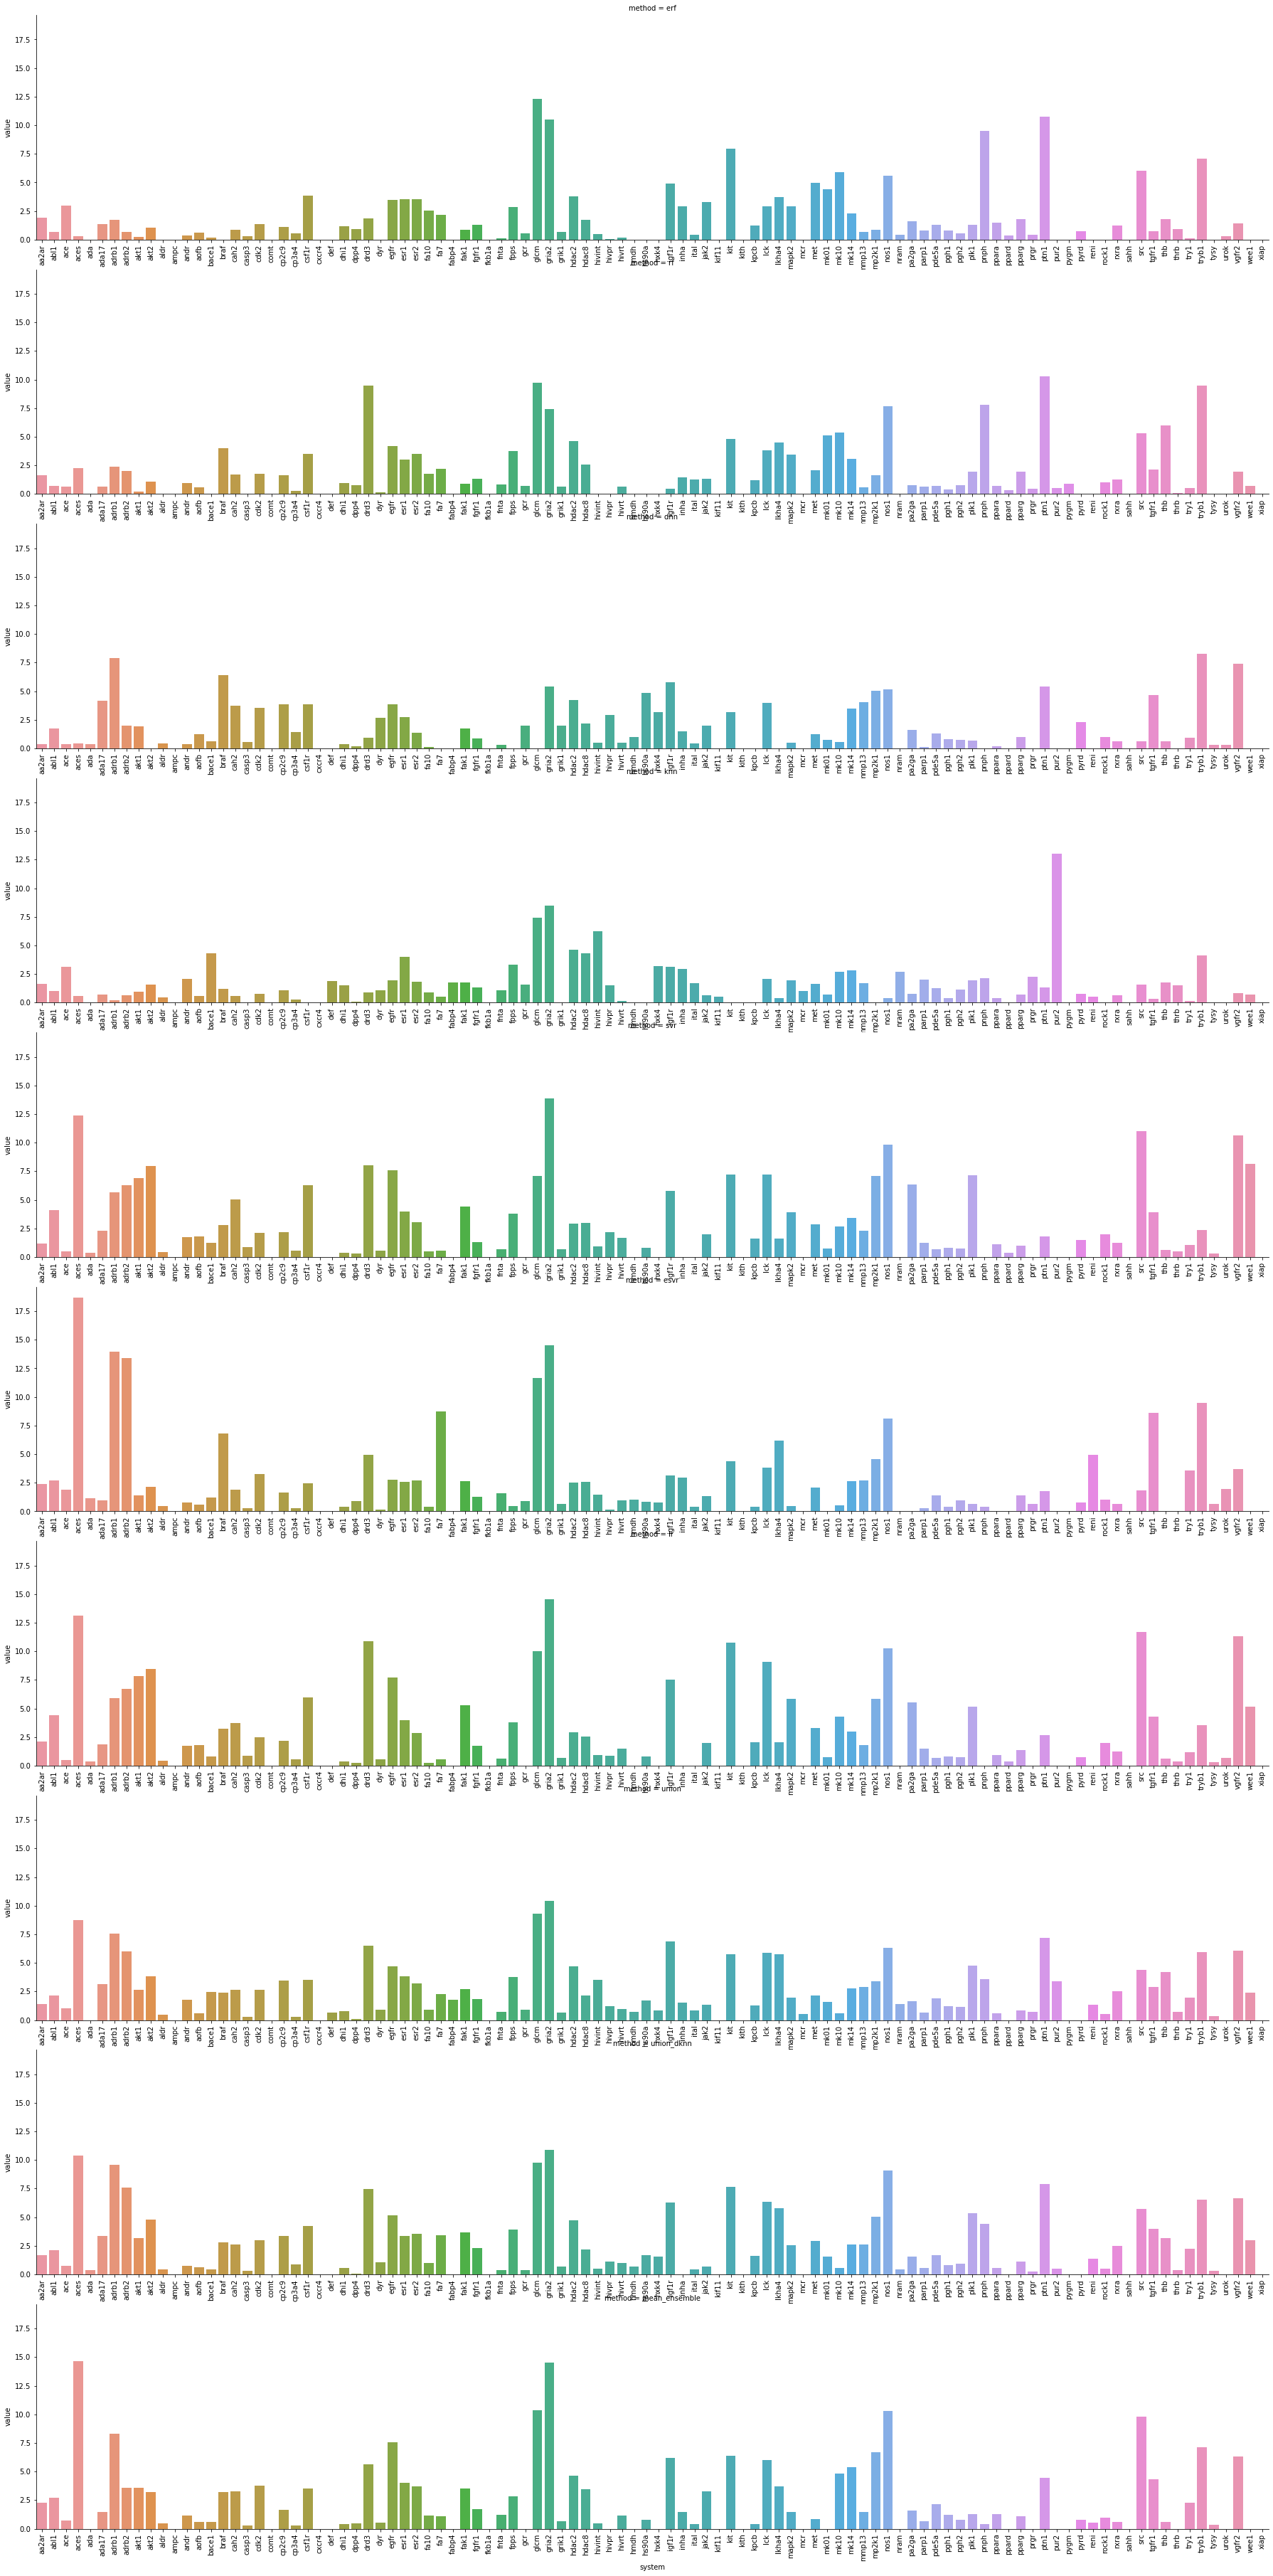

In [36]:
g = sns.catplot(data=enrichments.stack().rename('value').xs("0.01", level="level").reset_index(), kind='bar', x='system', y="value", col="method", col_wrap=1, aspect=5, sharex=False)
g.set_xticklabels(rotation=90)
